In [1]:
using JuMP, Clp, CSV, DataFrames, Statistics, Dualization, Distributions, Plots, StatsPlots

In [2]:
itsa4 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/itsa4.csv", DataFrame)
itsa4p = parse.(Float64,replace.(itsa4[!,:VARIAÇÃO],","=>"."))

mglu3 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/mglu3.csv", DataFrame)
mglu3p = parse.(Float64,replace.(mglu3[!,:VARIAÇÃO],","=>"."))

vale3 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection//vale3.csv", DataFrame)
vale3p = parse.(Float64,replace.(vale3[!,:VARIAÇÃO],","=>"."))

amer3 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/amer3.csv", DataFrame)
amer3p = parse.(Float64,replace.(amer3[!,:VARIAÇÃO],","=>"."))

lwsa3 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/lwsa3.csv", DataFrame)
lwsa3p = parse.(Float64,replace.(lwsa3[!,:VARIAÇÃO],","=>"."));

abev3 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/abev3.csv", DataFrame)
abev3p = parse.(Float64,replace.(abev3[!,:VARIAÇÃO],","=>"."));

sapr4 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/sapr4.csv", DataFrame)
sapr4p = parse.(Float64,replace.(sapr4[!,:VARIAÇÃO],","=>"."));

taee4 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/taee4.csv", DataFrame)
taee4p = parse.(Float64,replace.(taee4[!,:VARIAÇÃO],","=>"."));

ggbr4 = CSV.read("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/Assignments/Risk Averse Portifolio Selection/ggbr4.csv", DataFrame)
ggbr4p = parse.(Float64,replace.(ggbr4[!,:VARIAÇÃO],","=>"."));

assets_daily_returns = permutedims(hcat(reshape(itsa4p, 50),
                    reshape(mglu3p, 50),
                    reshape(vale3p, 50),
                    reshape(amer3p, 50),
                    reshape(lwsa3p, 50),
                    reshape(abev3p, 50),
                    reshape(sapr4p, 50),
                    reshape(taee4p, 50),
                    reshape(ggbr4p, 50)))

9×50 Matrix{Float64}:
  2.02  -3.71   1.07   1.54  -1.16  …  -0.87   0.61  -1.72   1.48  -0.78
 -3.5   -3.85  -1.92   2.75  -2.28     -4.19  -3.34   0.29   2.5   -0.44
 -3.28  -1.15  -0.94   1.87   0.0       0.46  -0.82  -0.06  -0.72   0.96
  1.69  -0.1    4.33   9.18  -1.52     -4.91  -7.88   2.47   1.22  -2.42
  5.19  -7.05   4.26  -1.3    2.85     -4.43  -0.96  -2.45   0.12  -0.96
  1.39  -3.07   0.71   0.13  -0.13  …  -1.5    0.42   0.06  -0.84  -2.62
 -1.0   -1.72   0.99   0.0    0.5      -0.26   3.16  -0.78  -0.26  -0.26
  0.32  -0.48  -0.08   0.56   0.72     -0.83   0.76  -0.68   0.84  -2.23
 -1.76  -1.24   0.07   0.0    1.92     -3.13  -1.01  -1.37   1.07   2.52

In [3]:
r̄ = []
ξ = []
assets = []
for i in 1:size(assets_daily_returns,1)
    append!(assets, i)
    append!(r̄, mean(assets_daily_returns[i,:]))
    append!(ξ, 2*std(assets_daily_returns[i,:]))
end
x = 2
Γ = 2
# (maximum(assets_daily_returns[2,:])+minimum(assets_daily_returns[2,:]))/2

2

In [4]:
model_inner_portfolio = Model(Clp.Optimizer)
set_optimizer_attribute(model_inner_portfolio, "LogLevel",0)

@variables(model_inner_portfolio,
begin
    r[assets]
    z[assets] ≥ 0
end)

@constraints(model_inner_portfolio,
begin
    ct1[i in assets], z[i]* ξ[i] - r[i] ≥ - r̄[i] 
    ct2[i in assets], z[i]* ξ[i] + r[i] ≥ r̄[i]
    ct3[i in assets], - z[i] ≥ - 1
    ct4, - sum(z[i] for i in assets) ≥ - Γ
end)

@objective(model_inner_portfolio, Min, sum(r[i]* x for i in assets))
optimize!(model_inner_portfolio);

println("================= Γ = $(Γ) =================\n")
println("objective_value = $(objective_value(model_inner_portfolio))")
println("r = $(round.([value.(r)[CartesianIndex(i)] for i in 1:9], digits=3))")
println("z = $(round.([value.(z)[CartesianIndex(i)] for i in 1:9], digits=3))")

================= Γ = 2 =================

objective_value = -35.2494114278102
r = [-0.05, -0.817, -0.491, -8.727, -7.117, -0.207, 0.068, -0.126, -0.158]
z = [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
dual_model_inner_portfolio = Model(Clp.Optimizer)
set_optimizer_attribute(dual_model_inner_portfolio, "LogLevel",0)

@variables(dual_model_inner_portfolio,
begin
    θpos[assets] ≥ 0
    θneg[assets] ≥ 0
    λ[assets] ≥ 0
    β ≥ 0
end)

@constraints(dual_model_inner_portfolio,
begin
    ct1[i in assets], -θneg[i] + θpos[i] == x
    ct2[i in assets], (θneg[i] + θpos[i])*ξ[i] -λ[i] - β ≤ 0
end)

@objective(dual_model_inner_portfolio, Max, -β * Γ - sum(λ[i] for i in assets) + sum(θpos[i]*r̄[i] - θneg[i]*r̄[i] for i in assets))
optimize!(dual_model_inner_portfolio);

println("================= Γ = $(Γ) =================\n")
println("objective_value = $(objective_value(dual_model_inner_portfolio))")
println("θpos = $(round.([value.(θpos)[CartesianIndex(i)] for i in 1:9], digits=3))")
println("θneg = $(round.([value.(θneg)[CartesianIndex(i)] for i in 1:9], digits=3))")
println("λ = $(round.([value.(λ)[CartesianIndex(i)] for i in 1:9], digits=3))")
println("β = $(round(value(β), digits=3))")

================= Γ = 2 =================

objective_value = -35.24941142781019
θpos = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
θneg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
λ = [0.0, 0.0, 0.0, 4.026, 0.786, 0.0, 0.0, 0.0, 0.0]
β = 12.992


## Single level formulation

================= Γ = 1 =================

objective_value = -0.6460545201498444
θpos = [0.137, 0.0, 0.121, 0.058, 0.071, 0.136, 0.156, 0.216, 0.105]
θneg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
λ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
β = 0.49
Ω = -0.646
x = [0.137, 0.0, 0.121, 0.058, 0.071, 0.136, 0.156, 0.216, 0.105]

================= Γ = 2 =================

objective_value = -1.1135096243610558
θpos = [0.128, 0.07, 0.112, 0.054, 0.066, 0.126, 0.145, 0.201, 0.098]
θneg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
λ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
β = 0.455
Ω = -1.114
x = [0.128, 0.07, 0.112, 0.054, 0.066, 0.126, 0.145, 0.201, 0.098]

================= Γ = 3 =================

objective_value = -1.5689923712407479
θpos = [0.128, 0.07, 0.112, 0.054, 0.066, 0.126, 0.145, 0.201, 0.098]
θneg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
λ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
β = 0.455
Ω = -1.569
x = [0.128, 0.07, 0.112, 0.054, 0.066, 0.1

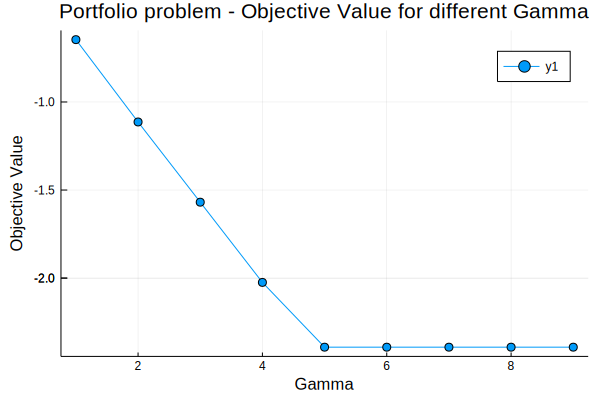

In [6]:
Γ_list = collect(1:1:9)
obj_value_dict = Dict{Float64, Float64}();
x_value_dict = Dict{Int64, Vector}();

for Γ in Γ_list
    model_portfolio = Model(Clp.Optimizer)
    set_optimizer_attribute(model_portfolio, "LogLevel",0)

    @variables(model_portfolio,
    begin
        θpos[assets] ≥ 0
        θneg[assets] ≥ 0
        λ[assets] ≥ 0
        β ≥ 0
        Ω
        x[assets] ≥ 0
    end)

    @constraints(model_portfolio,
    begin
        ct1[i in assets], Ω ≤ -β * Γ - sum(λ[i] for i in assets) + sum(θpos[i]*r̄[i] - θneg[i]*r̄[i] for i in assets)
        ct2[i in assets], -θneg[i] + θpos[i] == x[i]
        ct3[i in assets], (θneg[i] + θpos[i])*ξ[i] -λ[i] - β ≤ 0
        ct4, sum(x[i] for i in assets) == 1
    end)

    @objective(model_portfolio, Max, Ω)
    optimize!(model_portfolio);
    
    push!(obj_value_dict,Γ => objective_value(model_portfolio))
    x_list = [value.(x)[CartesianIndex(i)] for i in 1:9]
    push!(x_value_dict,Γ => x_list)

    println("================= Γ = $(Γ) =================\n")
    println("objective_value = $(objective_value(model_portfolio))")
    println("θpos = $(round.([value.(θpos)[CartesianIndex(i)] for i in 1:9], digits=3))")
    println("θneg = $(round.([value.(θneg)[CartesianIndex(i)] for i in 1:9], digits=3))")
    println("λ = $(round.([value.(λ)[CartesianIndex(i)] for i in 1:9], digits=3))")
    println("β = $(round(value(β), digits=3))")
    println("Ω = $(round(value(Ω), digits=3))")
    println("x = $(round.([value.(x)[CartesianIndex(i)] for i in 1:9], digits=3))")
    println("")
end
println(Γ_list)
Plots.plot(x=Γ_list, sort(obj_value_dict), shape = :circle,title = "Portfolio problem - Objective Value for different Gamma", xlabel = "Gamma", ylabel = "Objective Value")

## Post Optimization Analysis

OrderedCollections.OrderedDict{Int64, Vector{T} where T}(1 => [227, 0, 773], 2 => [91, 0, 909], 3 => [27, 0, 973], 4 => [5, 0, 995], 5 => [31, 0, 969], 6 => [31, 0, 969], 7 => [31, 0, 969], 8 => [31, 0, 969], 9 => [31, 0, 969])

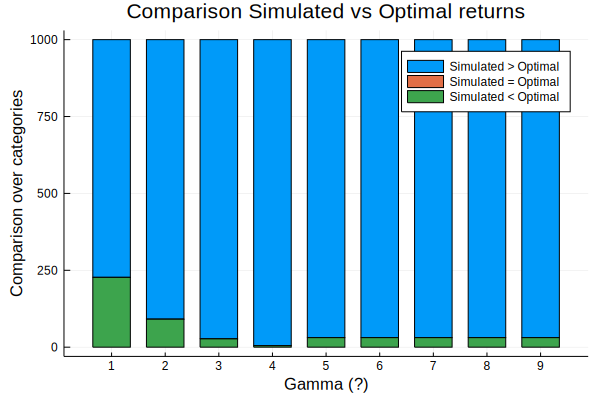

In [7]:
simulation_itsa4 = rand(Normal(mean(assets_daily_returns[1,:]), std(assets_daily_returns[1,:])),1000)
simulation_mglu3 = rand(Normal(mean(assets_daily_returns[2,:]), std(assets_daily_returns[2,:])),1000)
simulation_vale3 = rand(Normal(mean(assets_daily_returns[3,:]), std(assets_daily_returns[3,:])),1000)
simulation_amer3 = rand(Normal(mean(assets_daily_returns[4,:]), std(assets_daily_returns[4,:])),1000)
simulation_lwsa3 = rand(Normal(mean(assets_daily_returns[5,:]), std(assets_daily_returns[5,:])),1000)
simulation_abev3 = rand(Normal(mean(assets_daily_returns[6,:]), std(assets_daily_returns[6,:])),1000)
simulation_sapr4 = rand(Normal(mean(assets_daily_returns[7,:]), std(assets_daily_returns[7,:])),1000)
simulation_taee4 = rand(Normal(mean(assets_daily_returns[8,:]), std(assets_daily_returns[8,:])),1000)
simulation_ggbr4 = rand(Normal(mean(assets_daily_returns[9,:]), std(assets_daily_returns[9,:])),1000)

comparison_dict = Dict{Int64, Vector}()
comparison_sup_list = []
comparison_inf_list = []
comparison_eq_list = []
for Γ in Γ_list
    count_inf = 0
    count_equal = 0
    count_sup = 0
    
    for i in 1:1:1000
        simulated_return = sum(x_value_dict[Γ].*[simulation_itsa4[i],simulation_mglu3[i], simulation_vale3[i],
                                                simulation_amer3[i], simulation_lwsa3[i], simulation_abev3[i],
                                                simulation_sapr4[i], simulation_taee4[i], simulation_ggbr4[i]])
        if(simulated_return < obj_value_dict[Γ])
            count_inf += 1
        elseif (simulated_return == obj_value_dict[Γ])
            count_equal += 1
        else
            count_sup += 1
        end 
    end
    
    push!(comparison_dict, Γ => [count_inf, count_equal, count_sup])
    append!(comparison_sup_list,count_sup)
    append!(comparison_eq_list,count_equal)
    append!(comparison_inf_list,count_inf)
end

print(sort(comparison_dict))
ticklabel = string.(collect(1:9))
groupedbar([comparison_sup_list comparison_eq_list comparison_inf_list],
        bar_position = :stack,
        bar_width=0.7,
        xticks=(1:9, ticklabel),
        label=["Simulated > Optimal" "Simulated = Optimal" "Simulated < Optimal"],
        title = "Comparison Simulated vs Optimal returns",
        xlabel = "Gamma (Γ)",
        ylabel = "Comparison over categories",
        legend=:topright)
# Conforme eu vou aumentando o Γ menos casos tem que eu perco mais dinheiro do que o robusto previu (sim<opt)

## Data driven Uncertainty Set

In [8]:
model_dd_portfolio = Model(Clp.Optimizer)
set_optimizer_attribute(model_dd_portfolio, "LogLevel",0)

@variables(model_dd_portfolio,
begin
    Ω
    x[assets] ≥ 0
end)

@constraints(model_dd_portfolio,
begin
    ct1[s in 1:size(assets_daily_returns,2)], Ω ≤ sum(assets_daily_returns[i,s] for i in assets)
    ct2, sum(x[i] for i in assets) == 1
end)

@objective(model_dd_portfolio, Max, Ω)
optimize!(model_dd_portfolio);

println("objective_value = $(objective_value(model_dd_portfolio))")
println("Ω = $(round(value(Ω), digits=3))")
println("x = $(round.([value.(x)[CartesianIndex(i)] for i in 1:9], digits=3))")

objective_value = -40.45
Ω = -40.45
x = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
